In [2]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import random

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

'''Algos'''
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance, TimeSeriesKMeans

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

'''Dataset analysis'''
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from statistics import stdev
from math import sqrt

Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()
pair = [4,5,6,7]
anticlock_sequence = [3,2,1,0]
clockwise_sequence = [0,1,2,3]
location = {4:[-1,1],
            5:[1,1],
            6:[1,-1],
            7:[-1,-1]}
resolution = 40

C:\Users\TG0\PycharmProjects
D:\signal_ntd_trackpad


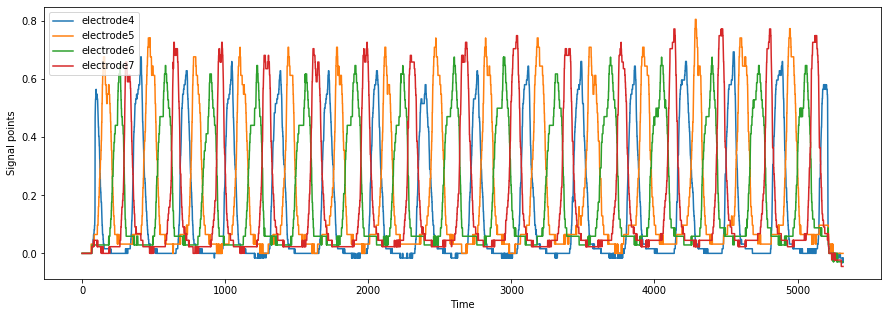

In [4]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

def get_electrode_data(filename):
    electrodes_points = pd.read_csv(filename)
    electrodes_points.columns = electrodes_points.columns.astype(float)
    electrodes_points.columns = electrodes_points.columns.astype(int)
    return electrodes_points.loc[:,pair]

def plot_electrode_data(electrodes_points):
    plt.figure(figsize= (15,5))
    for electrode in electrodes_points.columns:
        plt.plot(electrodes_points.index,electrodes_points.loc[:,electrode],label='electrode' + str(electrode))
    plt.xlabel('Time')
    plt.ylabel('Signal points')
    plt.legend()
    
plot_electrode_data(get_electrode_data('recording_v1.1_clockwise2.csv'))
# plt.xlim([0,10000])
# plot_electrode_data(get_electrode_data('circle.csv'))
# plot_electrode_data(get_electrode_data('y_axis.csv'))
# plt.xlim([0,1000])

In [5]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def find_peak(data,height=0.2,distance=350):
    peaks={}
    adjusted_peaks = {}
    for electrode in data.columns:
        peaks[electrode] = find_peaks(data.loc[:,electrode],height = height, distance= distance)[0]
        value = data.loc[:,electrode].to_numpy()
        for i,index in enumerate(peaks[electrode]):
            try: 
                segment = value[int(index-distance/3):int(index+distance/3)]
                popt,pcov = curve_fit(gaus,np.linspace(int(index-distance/3),int(index+distance/3-1),
                                                       int(index+distance/3-1) - int(index-distance/3) + 1),
                                      segment,p0=[value[index],index,distance/4])
                peaks[electrode][i] = int(popt[1])
            except:
                continue
        print('number of peaks in electrode ', electrode, ' = ',len(peaks[electrode]))
    return peaks

def plot_peaks(data,peaks):
    for electrode in data.columns:
        plt.plot(data.index[peaks[electrode]],data.loc[peaks[electrode],electrode],'x')
        

def electrode_sequence(sequence):
    elec_sequence=[]
    for i in sequence:
        elec_sequence.append(pair[i])
    return elec_sequence

def rotate(l,n):
    return l[n:] + l[:n]

def arrange_peaks_seq(peaks,elec_sequence):
#     print(peaks)
    
    start = min(chain(*peaks.values()))
    
    for key in peaks.keys():
        if start in peaks[key]:
            start_electrode = key

    
    while True:
        print(elec_sequence,start_electrode)
        if elec_sequence[0] == start_electrode:
            break
        else:
            elec_sequence = rotate(elec_sequence,1)
    i = 0
    final_peak = []
    final_sequence = []
    prev_peak = 0
    while True:
#         print('electrode_sequence',elec_sequence,peaks,elec_sequence[i%len(elec_sequence)])
        cycle = int(i/len(elec_sequence))
        try:
            peak = peaks[elec_sequence[i%len(elec_sequence)]][0]
#             print('peaks ',elec_sequence[i%len(elec_sequence)],' has peaks ', peaks[elec_sequence[i%len(elec_sequence)]])
        except:
            break
        if peak > prev_peak:
#             print('adding peaks',i,peak)
            final_peak.append(peak)
            prev_peak = peak
            peaks[elec_sequence[i%len(elec_sequence)]] = peaks[elec_sequence[i%len(elec_sequence)]][1:]
            final_sequence.append(elec_sequence[i%len(elec_sequence)])
        else:
            print('error in finding peaks',prev_peak,peak)
            break
        i += 1
    return final_peak,final_sequence

def arrange_coord_seq(final_sequence,direction='clockwise'):
    final_coords = []
    for i,elec in enumerate(final_sequence):
        final_coords.append(location[final_sequence[i]])
    final_coords = np.array(final_coords)
    return final_coords

def create_training_data_square(data,final_peak,final_coords):
    X_data = data.loc[final_peak[0],:].to_numpy()
    y_data = np.array(final_coords[0])
    
    for i,index in enumerate(final_peak):
        try:
            index_difference = (final_peak[i+1] - final_peak[i])/resolution         
        except:
            break
        
        X = data.loc[int(index),:].to_numpy()
        y = np.array(final_coords[i]).astype(float)
        print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from ',y)
        for j in range(resolution):
#             print('>>>>>>>>>>>>>  ',X,y)
            X_data = np.vstack((X_data,X))
            y_data = np.vstack((y_data,y))
            index += index_difference
            X = data.loc[int(index),:].to_numpy()
#             print('inside training data collection loop: ',i)        
            y_difference = (final_coords[i+1] - final_coords[i])/resolution
            y += y_difference 
#             print(y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data,y_data

def create_training_data_round(data,final_peak,angle_seq):
    def circle_direction(angle_seq):
        signs = np.sign([angle_seq[1]-angle_seq[0],angle_seq[2]-angle_seq[1],angle_seq[3]-angle_seq[2],angle_seq[0]-angle_seq[3]])
        direction = np.sign(np.sum(signs))
        if direction > 0:
            print('anticlockwise')
        else:
            print('clockwise')
        return direction
    direction = circle_direction(angle_seq)
    X_data = data.loc[final_peak[0],:].to_numpy()
    y_data = np.array([-np.sin(angle_seq[0]),np.cos(angle_seq[0])])
    i = 0
    while True:
        cycle = int(i/len(angle_seq))
        angle_index = i%len(angle_seq)
        try:
            X_difference = (data.loc[final_peak[i+1],:].to_numpy() - data.loc[final_peak[i],:].to_numpy())/resolution
        except:
            break
        X = data.loc[final_peak[i],:].to_numpy()
        y_difference = np.pi/2/resolution
        y = angle_seq[angle_index]
        for j in range(resolution):
            X_data = np.vstack((X_data,X))
            y_data = np.vstack((y_data,[-np.sin(y),np.cos(y)]))
            X += X_difference
            y = y + direction * y_difference 
            
        i+=1
    return X_data,y_data        
        

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
number of peaks in electrode  4  =  16
number of peaks in electrode  5  =  16
number of peaks in electrode  6  =  15
number of peaks in electrode  7  =  15
[4, 5, 6, 7]
[4, 5, 6, 7] 4
[4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 1.]
>>>>>>>>>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 1. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  1.]
>>>>>>>>>>>>>>>>>>>>>>

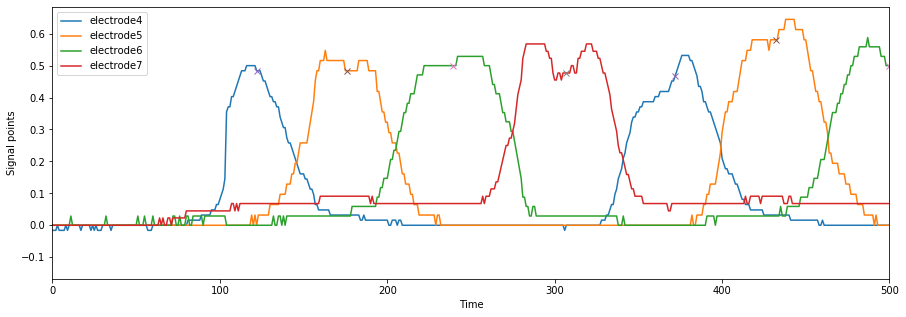

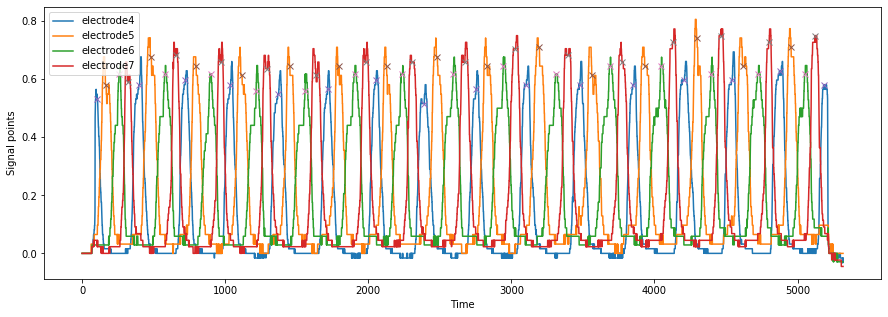

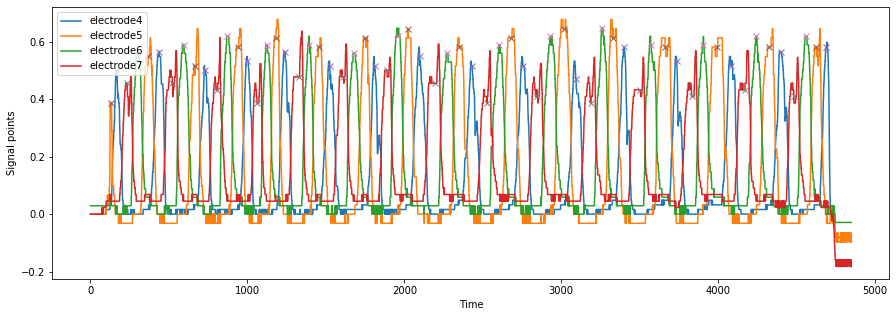

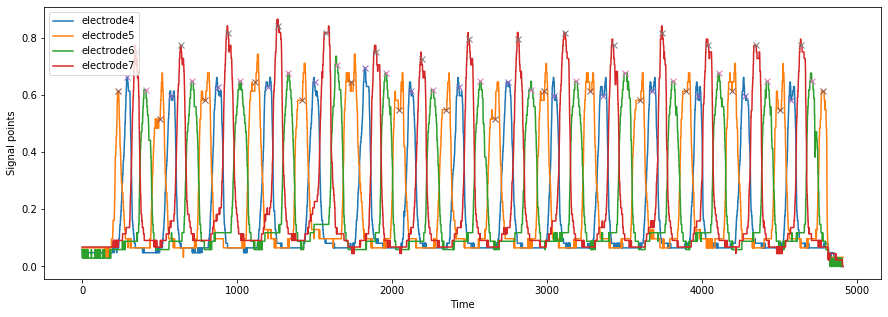

In [6]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())


circle_direction = 'clockwise'
data = get_electrode_data('recording_v1.1_'+circle_direction+'1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=150)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([0,500])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X1,y1 = create_training_data_square(data,final_peak,final_coords)



circle_direction = 'clockwise'
data = get_electrode_data('recording_v1.1_'+circle_direction+'2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=150)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X2,y2 = create_training_data_square(data,final_peak,final_coords)



circle_direction = 'anticlock'
data = get_electrode_data('recording_v1.1_'+circle_direction+'1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=150)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X3,y3 = create_training_data_square(data,final_peak,final_coords)



circle_direction = 'anticlock'
data = get_electrode_data('recording_v1.1_'+circle_direction+'2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.3,distance=150)
plot_electrode_data(data)
plot_peaks(data,peaks)
# plt.xlim([0,10000])

elec_sequence = electrode_sequence(eval(circle_direction+ '_sequence'))
print(elec_sequence)
final_peak,final_sequence = arrange_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrange_coord_seq(final_sequence,direction=circle_direction)
# print(final_coords)
X4,y4 = create_training_data_square(data,final_peak,final_coords)
# print(X1)


In [21]:

def plotacc(history,j):
    y = history.history['acc']
    x = range(1,len(y)+1)
    plt.plot(x,y,label=str(j) + ' datasets training ')
    
    return y[-1]
    
def plotval_loss(history):
    y = history.history['val_loss']
    x = range(1,len(y)+1)
    plt.plot(x,y)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Error")
    print('Minimum MSE: ', min(y))
    return y[-1]

def acc_eval(y_true, y_pred):
    for y in [y_true,y_pred]:
        if type(y) == pd.DataFrame:
            y = y.to_numpy()
    return np.average(np.sum(y_true - y_pred,axis=0))

In [1]:
for j in range(1,5):
    dataset_num = j
    X_data = np.vstack((eval('X'+str(i)) for i in range(1,dataset_num + 1)))
    y_data = np.vstack((eval('y'+str(i)) for i in range(1,dataset_num + 1)))


np.savetxt(r'D:\\signal_ntd_trackpad\V1.1_training_data.csv',np.hstack((X_data,y_data)),delimiter=",")
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)

model = Sequential()
model.add(Dense(units = 20,activation="linear", input_dim=4))
model.add(Dense(100, activation="linear"))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="linear"))
model.add(Dense(2, activation="linear"))
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 200
batch_size = 128
history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, y_train),verbose=1)

model_acc = plotacc(history,j)

y_pred = model.predict(X_test,verbose=1)
accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
# plt.plot(j*10, 1 - accuracy,'x',label='accuracy with ' + str(j) + ' datasets')
    
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.legend()
# plt.ylim([0.8,1])
print(os.getcwd())
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())

model.save('ntd_v1_trackpad_model.h5')

NameError: name 'np' is not defined

In [43]:
model.predict(np.array([[0.824, 0.036, 0.071, 0.118]]))

array([[-0.9276294,  0.7239417]], dtype=float32)